## Pipeline sceleton
airflow가 잘 설치되었다면 홈 디렉토리에 airflow 디렉토리가 생겼을 것이다.
여기에 DAG들을 만들어 넣어줄 폴더를 만들어준다.

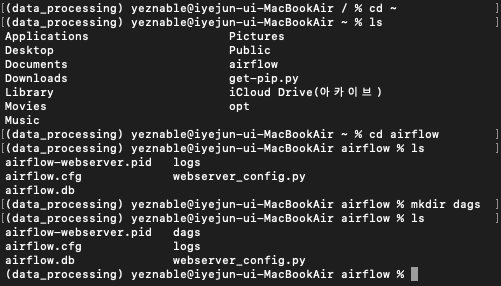

In [ ]:
# dags 디렉토리에 다음과 같은 코드를 넣어서 sceleton을 py 파일로 생성
# 생성한 pipeline이 UI에 적용될 때 까지는 30초 정도 걸릴 수 있다고 함
from datetime import datetime
from airflow import DAG

default_args = {
    'start_date' : datetime(2021,1,1),
}

with DAG(
        # airflow UI에서 보일 이름
        dag_id='nft-pipeline',
        # pipeline이 실행될 주기
        schedule_interval='@daily',
        default_args = default_args,
        # UI에서 보일 태그
        tag = ['nft'],
        # 에러가 있어서 실행하지 못한 기간이 있을 때 반응할 방법
        catchup=False) as dag:
    pass

sceleton이 만들어진 것을 확인할 수 있다.
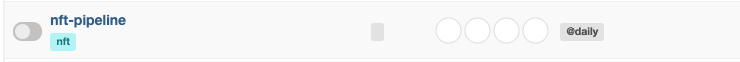

-------------------
## Operator

### 내장 Operator
1. BashOperator
2. PythonOperator
3. EmailOperator

### 외부 Operator
1. Action Operator > 액션을 실행
2. Transfer Operator > 데이터를 옮길 때 사용
3. Sensor > 조건이 맞을 때까지 기다림

-----------
nft-pipeline을 위해 sqlite table을 만들어줄 것이다.
이를 위해 SqliteOperator를 사용하고 Operator의 인자로 사용할 conn_id는 UI에서 다음의 과정을 통해 정의해줄 수 있다.

1. Admin > Connectios로 이동
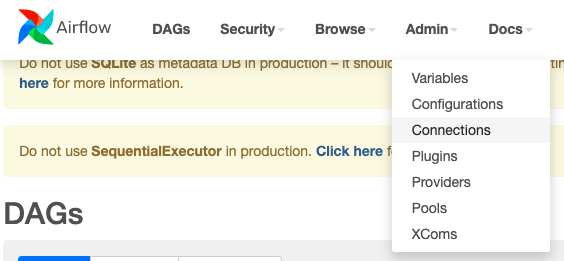

2. Add a new record 추가
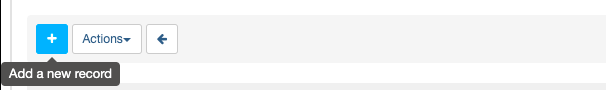

3. 다음과 같이 값을 넣어주고 저장
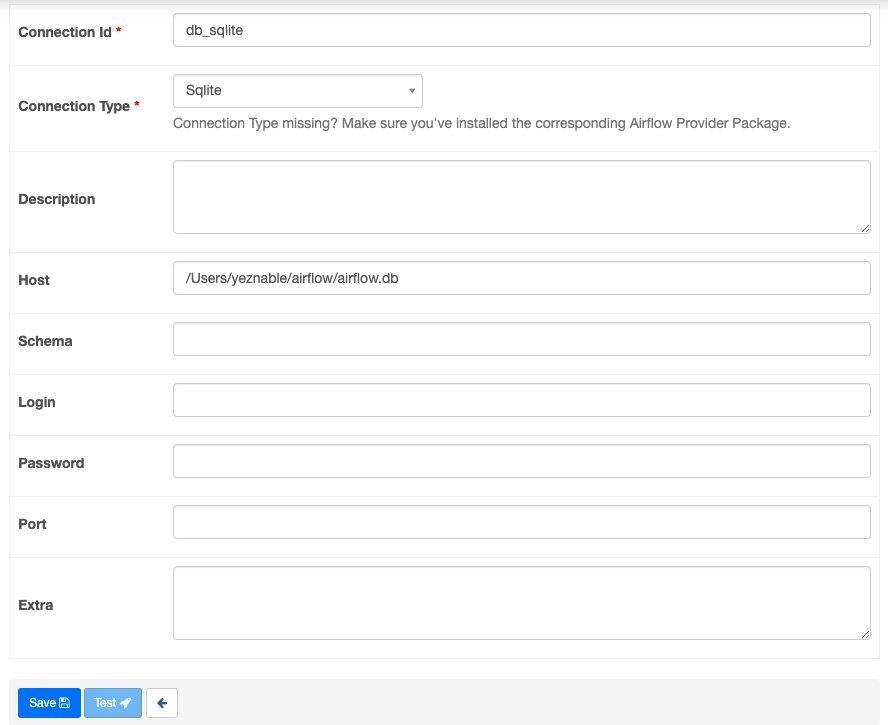

In [ ]:
# 만들어둔 sceleton nft-pipeline에 다음과 같이 task를 정의
from datetime import datetime

from airflow import DAG
from airflow.providers.sqlite.operators.sqlite import SqliteOperator

default_args = {
    'start_date' : datetime(2021,1,1),
}

with DAG(
        # airflow UI에서 보일 이름
        dag_id='nft-pipeline',
        # pipeline이 실행될 주기
        schedule_interval='@daily',
        default_args = default_args,
        # UI에서 보일 태그
        tags = ['nft'],
        # Backfill을 컨트롤
        catchup=False) as dag:

    creating_table = SqliteOperator(
        task_id='creating_table',
        sqlite_conn_id='db_sqlite',
        sql=
        '''
        CREATE TABEL IF NOT EXISTS nfts(
            token_id TEXT PRIMARY KEY
            name TEXT NOT NULL
            image_url TEXT NOT NULL
        )
        '''
    )

UI에서 nft-pipeline의 code로 들어가보면 다음과 같이 업데이트 된 것을 확인가능
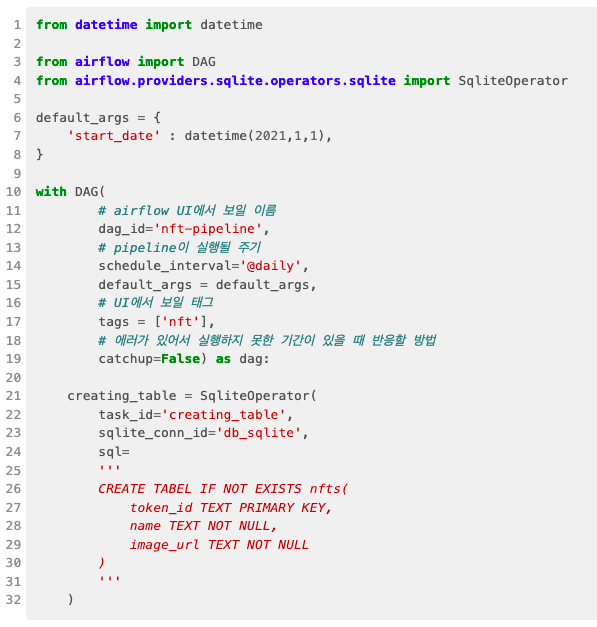

해당 task를 실행시키기 전까지 airflow sqlite db에는 nfts table이 없음
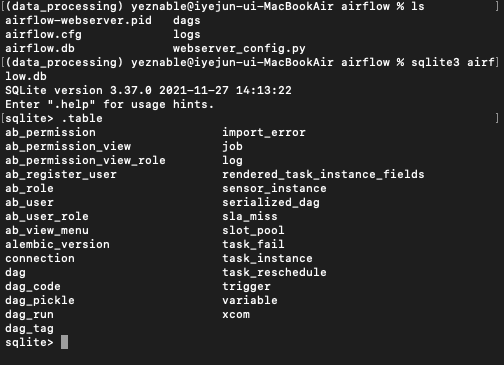

아래 명령어로 tasks를 test 가능  
% airflow tasks test nft-pipeline creating_table 2021-01-01

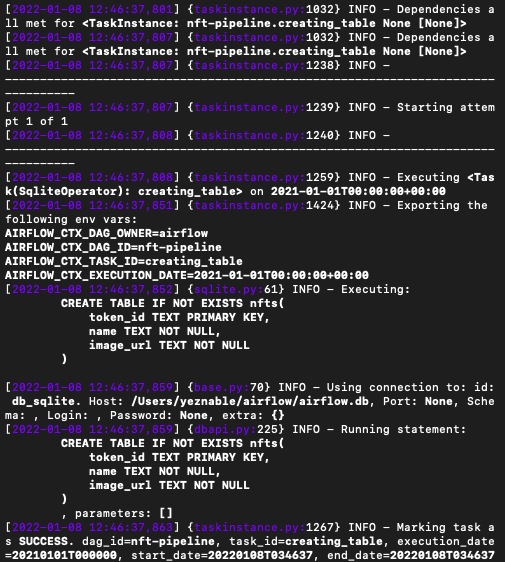
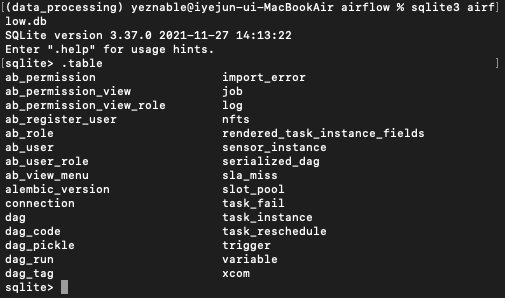
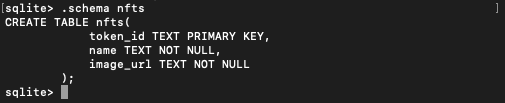

In [ ]:
# 기존 코드에 api가 존재하는지 확인하는 Sensor task를 추가
from datetime import datetime

from airflow import DAG
from airflow.providers.sqlite.operators.sqlite import SqliteOperator
from airflow.providers.http.sensors.http import HttpSensor

default_args = {
    'start_date' : datetime(2021,1,1),
}

with DAG(
        # airflow UI에서 보일 이름
        dag_id='nft-pipeline',
        # pipeline이 실행될 주기
        schedule_interval='@daily',
        default_args = default_args,
        # UI에서 보일 태그
        tags = ['nft'],
        # 에러가 있어서 실행하지 못한 기간이 있을 때 반응할 방법
        catchup=False) as dag:

    creating_table = SqliteOperator(
        task_id='creating_table',
        sqlite_conn_id='db_sqlite',
        sql=
        '''
        CREATE TABLE IF NOT EXISTS nfts(
            token_id TEXT PRIMARY KEY,
            name TEXT NOT NULL,
            image_url TEXT NOT NULL
        )
        '''
    )

    is_api_available = HttpSensor(
        task_id='is_api_available',
        http_conn_id='opeansea_api',
        endpoint='api/v1/assets?collection=doodles-official&limit=1'
    )

In [ ]:
# 기존 코드에 api를 통한 데이터 호출 task 추가
from datetime import datetime
import json

from airflow import DAG
from airflow.providers.sqlite.operators.sqlite import SqliteOperator
from airflow.providers.http.sensors.http import HttpSensor
from airflow.providers.http.operators.http import SimpleHttpOperator

default_args = {
    'start_date' : datetime(2021,1,1),
}

with DAG(
        # airflow UI에서 보일 이름
        dag_id='nft-pipeline',
        # pipeline이 실행될 주기
        schedule_interval='@daily',
        default_args = default_args,
        # UI에서 보일 태그
        tags = ['nft'],
        # 에러가 있어서 실행하지 못한 기간이 있을 때 반응할 방법
        catchup=False) as dag:

    creating_table = SqliteOperator(
        task_id='creating_table',
        sqlite_conn_id='db_sqlite',
        sql=
        '''
        CREATE TABLE IF NOT EXISTS nfts(
            token_id TEXT PRIMARY KEY,
            name TEXT NOT NULL,
            image_url TEXT NOT NULL
        )
        '''
    )

    is_api_available = HttpSensor(
        task_id='is_api_available',
        http_conn_id='opensea_api',
        endpoint='api/v1/assets?collection=doodles-official&limit=1'
    )

    extract_nft = SimpleHttpOperator(
        task_id='extract_nft',
        http_conn_id='opensea_api',
        endpoint='api/v1/assets?collection=doodles-official&limit=1',
        method="GET",
        response_filter=lambda res: json.loads(res.text),
        log_response=True
    )

task들이 제대로 반영된 것을 확인
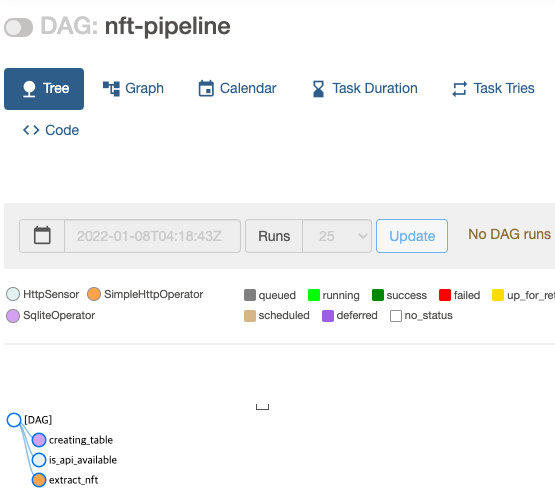

In [ ]:
# extract_nft를 통해 불러온 데이터를 PythonOperator로 csv형식 저장
from datetime import datetime
import json

from airflow import DAG
from airflow.providers.sqlite.operators.sqlite import SqliteOperator
from airflow.providers.http.sensors.http import HttpSensor
from airflow.providers.http.operators.http import SimpleHttpOperator
from airflow.operators.python import PythonOperator
from pandas import json_normalize

default_args = {
    'start_date' : datetime(2021,1,1),
}

def _processing_nft(ti):
    assets = ti.xcom_pull(task_ids=['extract_nft'])
    if not len(assets):
        raise ValueError("assets empty")

    nft = assets[0]['assets'][0]

    processed_nft = json_normalize({
        'token_id' : nft['token_id'],
        'name' : nft['name'],
        'image_url' : nft['image_url']
    })
    processed_nft.to_csv('/tmp/processed_nft.csv', index=None, header=False)

with DAG(
        # airflow UI에서 보일 이름
        dag_id='nft-pipeline',
        # pipeline이 실행될 주기
        schedule_interval='@daily',
        default_args = default_args,
        # UI에서 보일 태그
        tags = ['nft'],
        # 에러가 있어서 실행하지 못한 기간이 있을 때 반응할 방법
        catchup=False) as dag:

    creating_table = SqliteOperator(
        task_id='creating_table',
        sqlite_conn_id='db_sqlite',
        sql=
        '''
        CREATE TABLE IF NOT EXISTS nfts(
            token_id TEXT PRIMARY KEY,
            name TEXT NOT NULL,
            image_url TEXT NOT NULL
        )
        '''
    )

    is_api_available = HttpSensor(
        task_id='is_api_available',
        http_conn_id='opensea_api',
        endpoint='api/v1/assets?collection=doodles-official&limit=1'
    )

    extract_nft = SimpleHttpOperator(
        task_id='extract_nft',
        http_conn_id='opensea_api',
        endpoint='api/v1/assets?collection=doodles-official&limit=1',
        method="GET",
        response_filter=lambda res: json.loads(res.text),
        log_response=True
    )

    process_nft = PythonOperator(
        task_id='process_nft',
        python_callable=_processing_nft
    )

csv파일이 만들어진 것을 확인할 수 있다.
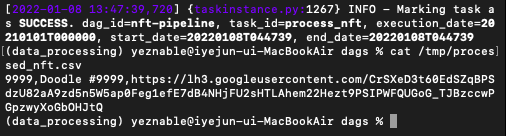

In [ ]:
# BashOperator를 통해 저장된 csv파일을 읽어 sqlite에 저장

from datetime import datetime
import json

from airflow import DAG
from airflow.providers.sqlite.operators.sqlite import SqliteOperator
from airflow.providers.http.sensors.http import HttpSensor
from airflow.providers.http.operators.http import SimpleHttpOperator
from airflow.operators.python import PythonOperator
from airflow.operators.bash import BashOperator

from pandas import json_normalize

default_args = {
    'start_date' : datetime(2021,1,1),
}

def _processing_nft(ti):
    assets = ti.xcom_pull(task_ids=['extract_nft'])
    if not len(assets):
        raise ValueError("assets empty")

    nft = assets[0]['assets'][0]

    processed_nft = json_normalize({
        'token_id' : nft['token_id'],
        'name' : nft['name'],
        'image_url' : nft['image_url']
    })
    processed_nft.to_csv('/tmp/processed_nft.csv', index=None, header=False)

with DAG(
        # airflow UI에서 보일 이름
        dag_id='nft-pipeline',
        # pipeline이 실행될 주기
        schedule_interval='@daily',
        default_args = default_args,
        # UI에서 보일 태그
        tags = ['nft'],
        # 에러가 있어서 실행하지 못한 기간이 있을 때 반응할 방법
        catchup=False) as dag:

    creating_table = SqliteOperator(
        task_id='creating_table',
        sqlite_conn_id='db_sqlite',
        sql=
        '''
        CREATE TABLE IF NOT EXISTS nfts(
            token_id TEXT PRIMARY KEY,
            name TEXT NOT NULL,
            image_url TEXT NOT NULL
        )
        '''
    )

    is_api_available = HttpSensor(
        task_id='is_api_available',
        http_conn_id='opensea_api',
        endpoint='api/v1/assets?collection=doodles-official&limit=1'
    )

    extract_nft = SimpleHttpOperator(
        task_id='extract_nft',
        http_conn_id='opensea_api',
        endpoint='api/v1/assets?collection=doodles-official&limit=1',
        method="GET",
        response_filter=lambda res: json.loads(res.text),
        log_response=True
    )

    process_nft = PythonOperator(
        task_id='process_nft',
        python_callable=_processing_nft
    )

    store_nft = BashOperator(
        task_id='store_nft',
        bash_command='echo -e ".separator" ,"\n.import /tmp/processed_nft.csv nfts" | sqlite3 /Users/yeznable/airflow/airflow.db'
    )

BashOperator를 tasks test로 실행해보면 다음과 같이 sqlite에 데이터가 저장된 것을 확인할 수 있다.

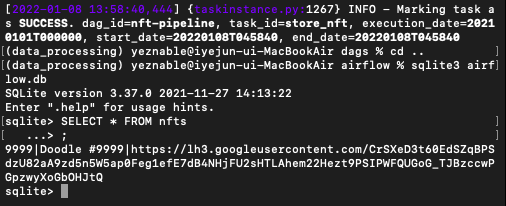

----------
여기까지 하면 필요한 task들을 모두 정의했지만 다음과 같이 task간의 의존성이 이어져있지 않은 상태이다.
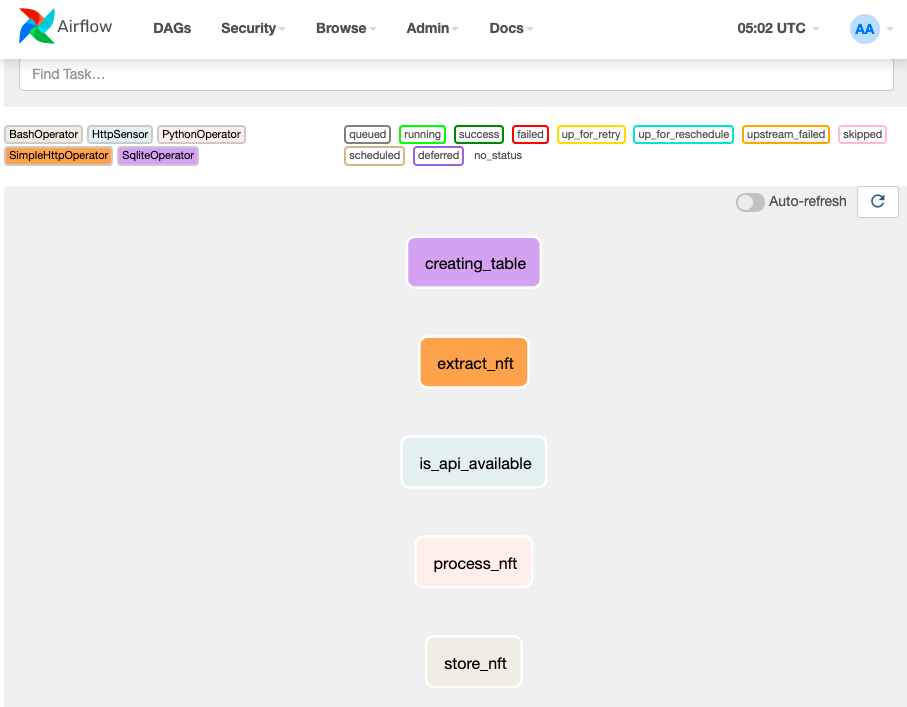

In [ ]:
#따라서 다음과 같이 코드 마지막에 의존성을 정의해주면 된다.
from datetime import datetime
import json

from airflow import DAG
from airflow.providers.sqlite.operators.sqlite import SqliteOperator
from airflow.providers.http.sensors.http import HttpSensor
from airflow.providers.http.operators.http import SimpleHttpOperator
from airflow.operators.python import PythonOperator
from airflow.operators.bash import BashOperator

from pandas import json_normalize

default_args = {
    'start_date' : datetime(2021,1,1),
}

def _processing_nft(ti):
    assets = ti.xcom_pull(task_ids=['extract_nft'])
    if not len(assets):
        raise ValueError("assets empty")

    nft = assets[0]['assets'][0]

    processed_nft = json_normalize({
        'token_id' : nft['token_id'],
        'name' : nft['name'],
        'image_url' : nft['image_url']
    })
    processed_nft.to_csv('/tmp/processed_nft.csv', index=None, header=False)

with DAG(
        # airflow UI에서 보일 이름
        dag_id='nft-pipeline',
        # pipeline이 실행될 주기
        schedule_interval='@daily',
        default_args = default_args,
        # UI에서 보일 태그
        tags = ['nft'],
        # 에러가 있어서 실행하지 못한 기간이 있을 때 반응할 방법
        catchup=False) as dag:

    creating_table = SqliteOperator(
        task_id='creating_table',
        sqlite_conn_id='db_sqlite',
        sql=
        '''
        CREATE TABLE IF NOT EXISTS nfts(
            token_id TEXT PRIMARY KEY,
            name TEXT NOT NULL,
            image_url TEXT NOT NULL
        )
        '''
    )

    is_api_available = HttpSensor(
        task_id='is_api_available',
        http_conn_id='opensea_api',
        endpoint='api/v1/assets?collection=doodles-official&limit=1'
    )

    extract_nft = SimpleHttpOperator(
        task_id='extract_nft',
        http_conn_id='opensea_api',
        endpoint='api/v1/assets?collection=doodles-official&limit=1',
        method="GET",
        response_filter=lambda res: json.loads(res.text),
        log_response=True
    )

    process_nft = PythonOperator(
        task_id='process_nft',
        python_callable=_processing_nft
    )

    store_nft = BashOperator(
        task_id='store_nft',
        bash_command='echo -e ".separator" ,"\n.import /tmp/processed_nft.csv nfts" | sqlite3 /Users/yeznable/airflow/airflow.db'
    )

creating_table >> is_api_available >> extract_nft >> process_nft >> store_nft

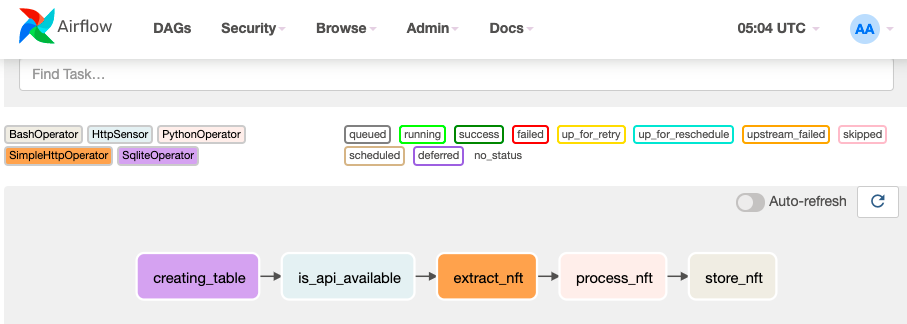